In [1]:
%pip install torchvision
%pip install torch --index-url https://download.pytorch.org/whl/cu118
%pip install tqdm

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour chang

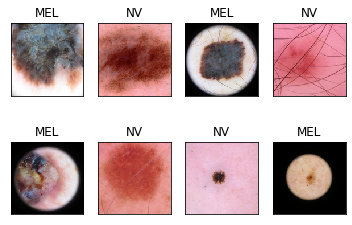

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

train_folder = ImageFolder('a5_data_new/train', transform=torchvision.transforms.ToTensor())
#train_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/train', transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(train_loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])


In [3]:
import torch
import torchvision
val_folder = ImageFolder('a5_data_new/val', transform=torchvision.transforms.ToTensor())
#val_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/val', transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(val_folder, batch_size=8, shuffle=True)

Got code from canvas to train our classfier. 

## Baseline CNN

In [4]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    
    # Binary Cross-entropy loss because we have 2 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.BCELoss()
      
    # Some statistics.
    acc_history = []

    for epoch in range(hyperparams['n_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()
        
        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):
            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)
            #print("labels ", Ybatch)
            #print("outputsshape ",outputs)
            #outputs=outputs[:]
            # Apply the cross-entropy loss.
            loss = loss_func(outputs.squeeze(), Ybatch.float())

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc = predict_and_evaluate(model, val_data)
                
        mean_loss = loss_sum / len(train_data)

        acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')
    
    return acc_history
        
    
# A utility function to compute accuracies during training.
def predict_and_evaluate(model, data):
    
    all_gold = []
    all_pred = []
    
    for Xbatch, Ybatch in data:
        outputs = model(Xbatch)
        predictions = torch.round(outputs)
        
        all_gold.extend(Ybatch.numpy())
        all_pred.extend(predictions.numpy())

    return accuracy_score(all_gold, all_pred) 

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class StepByStepCNN(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 64*30*30
        elif ks == 5:
            return 64*29*29
        else: 
            return 0 
           
    def forward(self, X):
        c1 = self.conv1(X)
        fm1 = F.max_pool2d(F.relu(c1), 2)
        c2 = self.conv2(fm1)
        fm2 = F.max_pool2d(F.relu(c2), 2)
        # This was used to calculate flattened size
        # print(fm2.shape)
        fl = torch.flatten(fm2, start_dim=1)
        h1 = F.relu(self.fc(fl))
        #print(h1)
        out = torch.sigmoid(self.output(h1))
        #print(out)
        return out

In [8]:
torch.random.manual_seed(2)
cnn = StepByStepCNN(5)
history = train_classifier(cnn, train_loader, val_loader,{'lr': 1e-3, 'n_epochs': 10})

100%|█████████████████████████████████████████| 804/804 [02:29<00:00,  5.37it/s]


Epoch 1: loss = 0.5659, val acc = 0.7460


100%|█████████████████████████████████████████| 804/804 [02:29<00:00,  5.37it/s]


Epoch 2: loss = 0.4996, val acc = 0.7396


100%|█████████████████████████████████████████| 804/804 [02:29<00:00,  5.38it/s]


Epoch 3: loss = 0.4844, val acc = 0.7620


100%|█████████████████████████████████████████| 804/804 [02:30<00:00,  5.33it/s]


Epoch 4: loss = 0.4697, val acc = 0.7380


100%|█████████████████████████████████████████| 804/804 [02:28<00:00,  5.43it/s]


Epoch 5: loss = 0.4409, val acc = 0.7556


100%|█████████████████████████████████████████| 804/804 [02:28<00:00,  5.41it/s]


Epoch 6: loss = 0.4005, val acc = 0.7827


100%|█████████████████████████████████████████| 804/804 [02:28<00:00,  5.41it/s]


Epoch 7: loss = 0.3709, val acc = 0.7724


100%|█████████████████████████████████████████| 804/804 [02:30<00:00,  5.34it/s]


Epoch 8: loss = 0.3399, val acc = 0.7580


100%|█████████████████████████████████████████| 804/804 [02:30<00:00,  5.36it/s]


Epoch 9: loss = 0.2900, val acc = 0.7620


100%|█████████████████████████████████████████| 804/804 [02:31<00:00,  5.32it/s]


Epoch 10: loss = 0.2861, val acc = 0.7548


## CNN with Batch Normalization

In [11]:
class StepByStepCNN_batch(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization layer after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization layer after conv2
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 64 * 30 * 30
        elif ks == 5:
            return 64 * 29 * 29
        else:
            return 0 

    def forward(self, X):
        c1 = self.conv1(X)
        fm1 = F.max_pool2d(F.relu(self.bn1(c1)), 2)  # Apply Batch Normalization and ReLU
        c2 = self.conv2(fm1)
        fm2 = F.max_pool2d(F.relu(self.bn2(c2)), 2)  # Apply Batch Normalization and ReLU
        fl = torch.flatten(fm2, start_dim=1)
        h1 = F.relu(self.fc(fl))
        out = torch.sigmoid(self.output(h1))
        return out

torch.random.manual_seed(2)
cnn = StepByStepCNN_batch(5)
history = train_classifier(cnn, train_loader, val_loader, {'lr': 1e-3, 'n_epochs': 10})

100%|█████████████████████████████████████████| 804/804 [02:37<00:00,  5.11it/s]


Epoch 1: loss = 32.7680, val acc = 0.6398


100%|█████████████████████████████████████████| 804/804 [02:34<00:00,  5.20it/s]


Epoch 2: loss = 37.6449, val acc = 0.5815


100%|█████████████████████████████████████████| 804/804 [02:38<00:00,  5.07it/s]


Epoch 3: loss = 33.7387, val acc = 0.7013


100%|█████████████████████████████████████████| 804/804 [03:01<00:00,  4.43it/s]


Epoch 4: loss = 33.0227, val acc = 0.6813


100%|█████████████████████████████████████████| 804/804 [02:53<00:00,  4.63it/s]


Epoch 5: loss = 33.4795, val acc = 0.6805


100%|█████████████████████████████████████████| 804/804 [02:55<00:00,  4.58it/s]


Epoch 6: loss = 33.6978, val acc = 0.6573


100%|█████████████████████████████████████████| 804/804 [02:47<00:00,  4.79it/s]


Epoch 7: loss = 36.0541, val acc = 0.6589


100%|█████████████████████████████████████████| 804/804 [02:32<00:00,  5.27it/s]


Epoch 8: loss = 38.2183, val acc = 0.6573


100%|█████████████████████████████████████████| 804/804 [02:32<00:00,  5.27it/s]


Epoch 9: loss = 35.7134, val acc = 0.6558


100%|█████████████████████████████████████████| 804/804 [02:32<00:00,  5.29it/s]


Epoch 10: loss = 36.1656, val acc = 0.4625


## CNN with Layer Normalization

In [12]:
class StepByStepCNN_layer(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.ln1 = nn.LayerNorm([32, 61, 61])  # Layer Normalization layer after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.ln2 = nn.LayerNorm([64, 29, 29])  # Layer Normalization layer after conv2
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 64 * 30 * 30
        elif ks == 5:
            return 64 * 29 * 29
        else:
            return 0 

    def forward(self, X):
        c1 = self.conv1(X)
        fm1 = F.max_pool2d(F.relu(self.ln1(c1)), 2)  # Apply Layer Normalization and ReLU
        c2 = self.conv2(fm1)
        fm2 = F.max_pool2d(F.relu(self.ln2(c2)), 2)  # Apply Layer Normalization and ReLU
        fl = torch.flatten(fm2, start_dim=1)
        h1 = F.relu(self.fc(fl))
        out = torch.sigmoid(self.output(h1))
        return out

torch.random.manual_seed(2)
cnn = StepByStepCNN_layer(5)
history = train_classifier(cnn, train_loader, val_loader, {'lr': 1e-3, 'n_epochs': 10})

  0%|                                                   | 0/804 [00:00<?, ?it/s]


RuntimeError: Given normalized_shape=[32, 61, 61], expected input with shape [*, 32, 61, 61], but got input of size[8, 32, 124, 124]

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StepByStepCNN_layer(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel RGB
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks, padding=ks//2)  # Add padding
        self.ln1 = nn.LayerNorm([32, 128, 128])  # Adjust Layer Normalization layer after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks, padding=ks//2)  # Add padding
        self.ln2 = nn.LayerNorm([64, 64, 64])  # Adjust Layer Normalization layer after conv2
        self.fc = nn.Linear(64 * 32 * 32, 512)  # Correct the input size of the fully connected layer
        self.output = nn.Linear(512, 1)

    def forward(self, X):
        c1 = self.conv1(X)
        fm1 = F.max_pool2d(F.relu(self.ln1(c1)), 2)  # Apply Layer Normalization and ReLU
        c2 = self.conv2(fm1)
        fm2 = F.max_pool2d(F.relu(self.ln2(c2)), 2)  # Apply Layer Normalization and ReLU
        fl = torch.flatten(fm2, start_dim=1)
        h1 = F.relu(self.fc(fl))
        out = torch.sigmoid(self.output(h1))
        return out

# Example usage:
torch.manual_seed(2)
cnn = StepByStepCNN_layer(5)
history = train_classifier(cnn, train_loader, val_loader, {'lr': 1e-3, 'n_epochs': 10})


100%|█████████████████████████████████████████| 804/804 [03:21<00:00,  4.00it/s]


Epoch 1: loss = 49.8685, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:19<00:00,  4.02it/s]


Epoch 2: loss = 50.0000, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:18<00:00,  4.04it/s]


Epoch 3: loss = 50.0466, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:19<00:00,  4.03it/s]


Epoch 4: loss = 50.0466, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:19<00:00,  4.03it/s]


Epoch 5: loss = 50.0466, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:18<00:00,  4.04it/s]


Epoch 6: loss = 50.0000, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:19<00:00,  4.03it/s]


Epoch 7: loss = 50.0466, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:19<00:00,  4.03it/s]


Epoch 8: loss = 50.0000, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:19<00:00,  4.03it/s]


Epoch 9: loss = 50.0000, val acc = 0.5000


100%|█████████████████████████████████████████| 804/804 [03:18<00:00,  4.05it/s]


Epoch 10: loss = 50.0000, val acc = 0.5000


## CNN with Residual Connection

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StepByStepCNN_RC(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel RGB
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks, padding=ks//2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks, padding=ks//2)
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

        # Adding 1x1 conv layers for residual connections if input and output channels differ
        self.res_conv1 = nn.Conv2d(3, 32, kernel_size=1) if 3 != 32 else None
        self.res_conv2 = nn.Conv2d(32, 64, kernel_size=1) if 32 != 64 else None

    def flatten_size(self, ks):
        if ks == 3:
            return 64 * 30 * 30
        elif ks == 5:
            return 64 * 29 * 29
        else:
            return 0

    def forward(self, X):
        # First residual block
        residual1 = self.res_conv1(X) if self.res_conv1 else X
        c1 = self.conv1(X)
        fm1 = F.relu(F.max_pool2d(c1 + residual1, 2))

        # Second residual block
        residual2 = self.res_conv2(fm1) if self.res_conv2 else fm1
        c2 = self.conv2(fm1)
        fm2 = F.relu(F.max_pool2d(c2 + residual2, 2))

        # Flatten and fully connected layers
        fl = torch.flatten(fm2, start_dim=1)
        h1 = F.relu(self.fc(fl))
        out = torch.sigmoid(self.output(h1))
        
        return out

torch.random.manual_seed(2)
cnn = StepByStepCNN_RC(5)
history = train_classifier(cnn, train_loader, val_loader, {'lr': 1e-3, 'n_epochs': 10})


  0%|                                                   | 0/804 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x65536 and 53824x512)